# MODEL SELECTION
1) Random Forest using optuna
2) XGBoost using optuna
3) SHAP
4) Pycaret

## Setting up the directory, and importing files to work with

In [1]:
# set working directory
import os
os.getcwd()

'/Users/gaby/Documents/NYCDSA/ML project'

In [2]:
import pandas as pd
df = pd.read_pickle("df.pkl")

In [ ]:
#`conda install -c conda-forge optuna

In [4]:
# importing the data
import joblib
scaler = joblib.load("scaler.pkl")
X_train_scaled = joblib.load("X_train_scaled.pkl")
X_test_scaled = joblib.load("X_test_scaled.pkl")
y_train = joblib.load("y_train.pkl")
y_test = joblib.load("y_test.pkl")

# RANDOM FOREST

In [ ]:
# RANDOM FOREST
from sklearn import ensemble
import optuna 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import json


### Predictions with cross validation and hyperparameter tuning using optuna

In [11]:
# Define the objective function for hyperparameter tuning.
def objective(trial):
    params = {
        # Suggest values for the hyperparameters
        "n_estimators" : trial.suggest_int("n_estimators", 100, 1000), # number of trees in the forest. 
        "max_depth" : trial.suggest_int("max_depth", 2, 32, log=True), # maximum depth. Limits between shallow and deep trees.
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 10), # min samples in an internal node
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "random_state" : 42,
        "n_jobs" : -1

    }
    
    # Create a RandomForestRegressor with the trial's hyperparameters
    rf = RandomForestRegressor(**params)

    # Evaluate with cross-validation (using negative MSE)
    return cross_val_score(
        rf,
        X_train_scaled,
        y_train,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
        ).mean()

# Run Optuna study
study = optuna.create_study(direction="maximize") # a higher, less negative value corresponds to better performance
study.optimize(objective, n_trials=50)

# We are going to rename the dictionary of best parameters and add to it with a couple of more entries
best_rf_params = study.best_params
best_rf_params.update({'random_state': 42, 'n_jobs': -1})

# Train final model using best parameters on training data
'''RandomForestRegressor(
  n_estimators=best_rf_params['n_estimators'],
  max_depth=   best_rf_params['max_depth'],
  # …and so on for every key/value in that dict…
)'''

rf_best = RandomForestRegressor(**best_rf_params)
rf_best.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf_best.predict(X_test_scaled)

# save best params to a json file

with open("best_rf_params.json", "w") as f:
    json.dump(best_rf_params, f)
print("Best parameters have been saved to best_rf_params.json")

[I 2025-04-16 15:45:59,381] A new study created in memory with name: no-name-208e7530-5efd-4fc7-a75a-e534d342cfd1
[I 2025-04-16 15:46:26,609] Trial 0 finished with value: -651551723.784768 and parameters: {'n_estimators': 997, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: -651551723.784768.
[I 2025-04-16 15:46:44,362] Trial 1 finished with value: -693643673.8605719 and parameters: {'n_estimators': 944, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: -651551723.784768.
[I 2025-04-16 15:46:58,774] Trial 2 finished with value: -668669624.8061316 and parameters: {'n_estimators': 804, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: -651551723.784768.
[I 2025-04-16 15:47:04,041] Trial 3 finished with value: -1655748378.5510497 and parameters: {'n_estimators': 781, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with valu

Best parameters have been saved to best_rf_params.json


### RANDOM FOREST: Evaluation metrics with best parameters identified in optuna


In [13]:
import json
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

with open("best_rf_params.json", "r") as f:
    loaded_best_rf_params = json.load(f)

# 2. Initialize & train the model (no duplicate random_state)
rf_loaded = RandomForestRegressor(**loaded_best_rf_params)
rf_loaded.fit(X_train_scaled, y_train)

# Print regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

MSE: 660358997.5307
RMSE: 25697.4512
MAE: 15791.2633
R^2: 0.8927


# XGBoost

### XGBoost: Hyperparameter tuning with cross-validation for XGBoost

In [ ]:
#
# 
# +!pip install xgboost

In [17]:
from xgboost import XGBRegressor

def objective(trial):
    params = {
        # Suggest values for the hyperparameters
        "n_estimators" : trial.suggest_int("n_estimators", 100, 1000),
        "max_depth" : trial.suggest_int("max_depth", 2, 32, log=True),
        "learning_rate" : trial.suggest_float("learning_rate", 1e-4, 1.0, log=True),
        "subsample" : trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state" : 42,
        "n_jobs" : -1

    }
    
    xgb = XGBRegressor(**params)
    
    # Evaluate with cross-validation (using negative MSE)
    return cross_val_score(
        xgb,
        X_train_scaled,
        y_train,
        cv=5,
        scoring="neg_mean_squared_error"
    ).mean()

# Create Optuna study
study_xgb = optuna.create_study(direction="maximize")

# Run the optimization
study_xgb.optimize(objective, n_trials=50)

# 4Output the best hyperparameters
best_xgb_params = study_xgb.best_trial.params
print("Best hyperparameters:", best_xgb_params)

# Train the final model using the best parameters on the full training data
xgb_best = XGBRegressor(**best_xgb_params, random_state=42)
xgb_best.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = xgb_best.predict(X_test_scaled)

# Save the best parameters to a JSON file
with open("best_xgb_params.json", "w") as f:
    json.dump(best_xgb_params, f)
print("Best XGBoost parameters have been saved to best_xgb_params.json")

[I 2025-04-16 17:48:37,653] A new study created in memory with name: no-name-c6571e27-f247-479c-b950-dd89ffdcaddc
[I 2025-04-16 17:48:43,891] Trial 0 finished with value: -4787833306.492159 and parameters: {'n_estimators': 713, 'max_depth': 3, 'learning_rate': 0.00014258744700231188, 'subsample': 0.7889830331033243, 'colsample_bytree': 0.9684199736793431}. Best is trial 0 with value: -4787833306.492159.
[I 2025-04-16 17:49:11,396] Trial 1 finished with value: -3521653743.5252237 and parameters: {'n_estimators': 759, 'max_depth': 11, 'learning_rate': 0.000400586606522333, 'subsample': 0.5312887878561104, 'colsample_bytree': 0.8425524711502885}. Best is trial 1 with value: -3521653743.5252237.
[I 2025-04-16 17:49:15,040] Trial 2 finished with value: -1248643765.3421896 and parameters: {'n_estimators': 515, 'max_depth': 3, 'learning_rate': 0.9796358461140918, 'subsample': 0.8190484490309644, 'colsample_bytree': 0.7555563665060754}. Best is trial 2 with value: -1248643765.3421896.
[I 2025-

Best hyperparameters: {'n_estimators': 470, 'max_depth': 4, 'learning_rate': 0.04506081546963628, 'subsample': 0.5482124838109351, 'colsample_bytree': 0.6162305690166746}
Best XGBoost parameters have been saved to best_xgb_params.json


In [18]:
from xgboost import XGBRegressor

# Load the best params
with open("best_xgb_params.json", "r") as f:
    loaded_best_xgb_params = json.load(f)

# Create and train a new XGBRegressor with these hyperparams
xgb_loaded = XGBRegressor(**loaded_best_xgb_params, random_state=42)
xgb_loaded.fit(X_train_scaled, y_train)

# Evaluate again
y_pred_loaded = xgb_loaded.predict(X_test_scaled)

mse_loaded = mean_squared_error(y_test, y_pred_loaded)
rmse_loaded = np.sqrt(mse_loaded)
mae_loaded = mean_absolute_error(y_test, y_pred_loaded)
r2_loaded = r2_score(y_test, y_pred_loaded)

print(f"Reloaded model - MSE: {mse_loaded:.4f}")
print(f"Reloaded model - RMSE: {rmse_loaded:.4f}")
print(f"Reloaded model - MAE: {mae_loaded:.4f}")
print(f"Reloaded model - R^2: {r2_loaded:.4f}")

Reloaded model - MSE: 415932591.2181
Reloaded model - RMSE: 20394.4255
Reloaded model - MAE: 12886.0088
Reloaded model - R^2: 0.9324


### XGBoost: Shapley Values

In [20]:
!pip install shap

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)


In [ ]:
import shap

Each feature's Shapley value represents its average marginal contribution across all possible combinations of features. 

They consider how much each feature contributes to the overall outcome. 

The Shapley value analysis reveals that features like "overall quality" and "above gorund living area" had the most significant positive impact, while "age of the house" had a negative impact in the positive or negative direction. 

https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/?xgtab&
https://www.aidancooper.co.uk/how-shapley-values-work/

In [ ]:
''' Mean absolute SHAP values indicate how much a variable impacts the predicted
house price, '''

In [62]:
# # explanatio you can call with feature contributions
# shap_explainer = shap.Explainer(xgb_loaded, X_train_scaled)
# # compute feature contributions for each row
# shap_explanation = shap_explainer(X_train_scaled)
# shap_values = shap_explanation.values
# # wrap up the numpy array into a dataframe, and assign each column of SHAP
# # values the original feature name
# shap_values_df = pd.DataFrame(shap_values, columns = X_train_scaled.columns)

# shap.summary_plot(shap_values_df.values, # shap values array
#                   shap_values_df, # provides feature names
#                   plot_type = "bar",
#                   max_display = 25) 


 94%|=================== | 1946/2064 [00:15<00:00]       

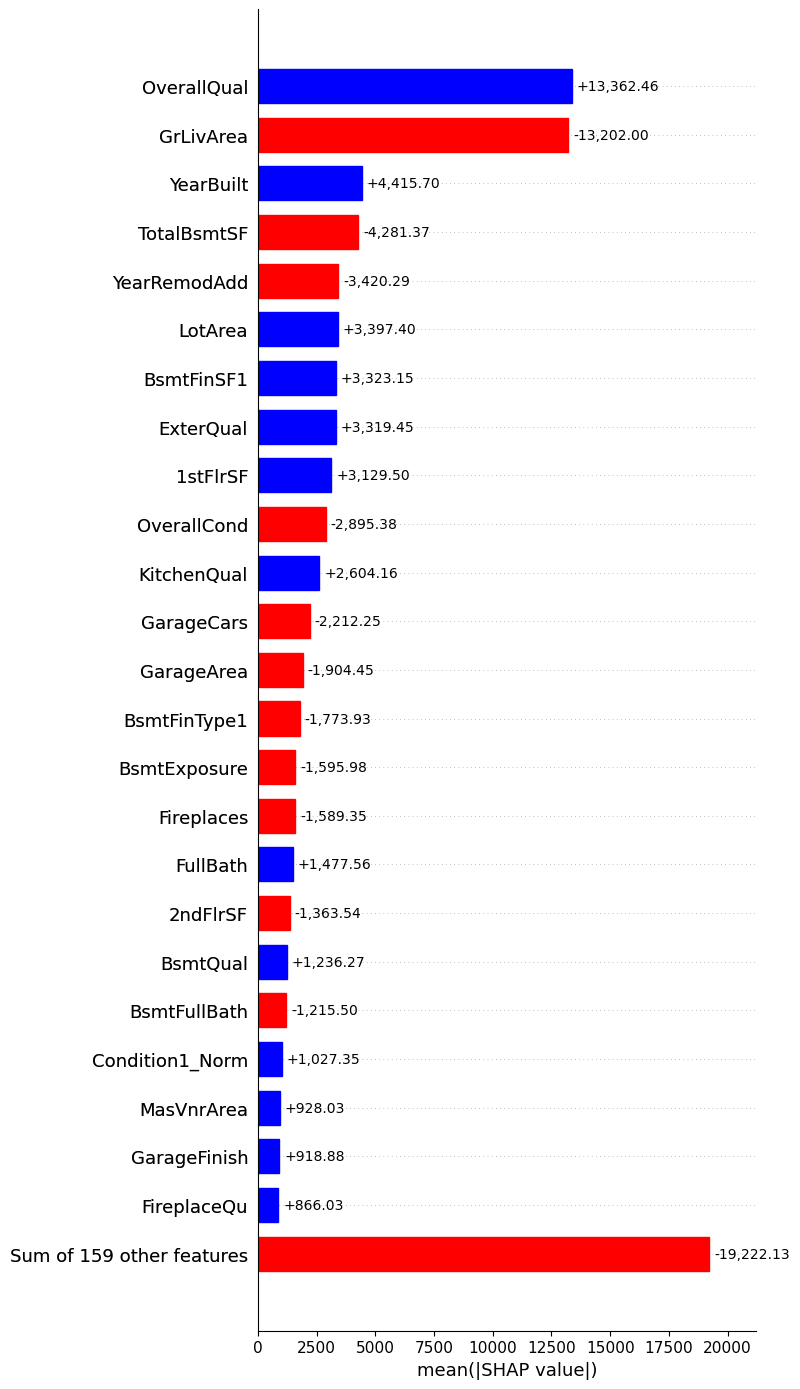

In [48]:
explainer    = shap.Explainer(xgb_loaded, X_train_scaled)
shap_expln   = explainer(X_train_scaled)

# 2) Draw the bar chart w/o showing
fig = shap.plots.bar(shap_expln, max_display=25, show=False)
ax  = plt.gca()

# 3) Remove all of the default text labels
for txt in list(ax.texts):
    txt.remove()

# 4) Re‑color and re‑label
for bar, feat in zip(ax.patches, shap_expln.feature_names[:25]):
    corr = np.corrcoef(shap_values_df[feat], X_train_scaled[feat])[0,1]
    # color by sign
    bar.set_color('blue' if corr>0 else 'red')
    # build your own signed label
    sign = '+' if corr>0 else '-'
    val  = bar.get_width()
    label = f"{sign}{val:,.2f}"
    # place it
    ax.text(
        val + ax.get_xlim()[1]*0.01,
        bar.get_y() + bar.get_height()/2,
        label,
        va='center',
        color='black'
    )

# 5) Show
plt.tight_layout()
plt.show()

On average, changing FireplaceQu (one level up or down) shifts the model’s predicted sale price by about $866.

GrLivArea is the single most influential feature in your model (mean impact ≈ $13 k).

The fact that its bar is red tells you that, in your dataset, bigger houses actually 

pull the model’s prediction down relative to the baseline (perhaps because very 

large homes in your data come with features that the model “discounts” on average).


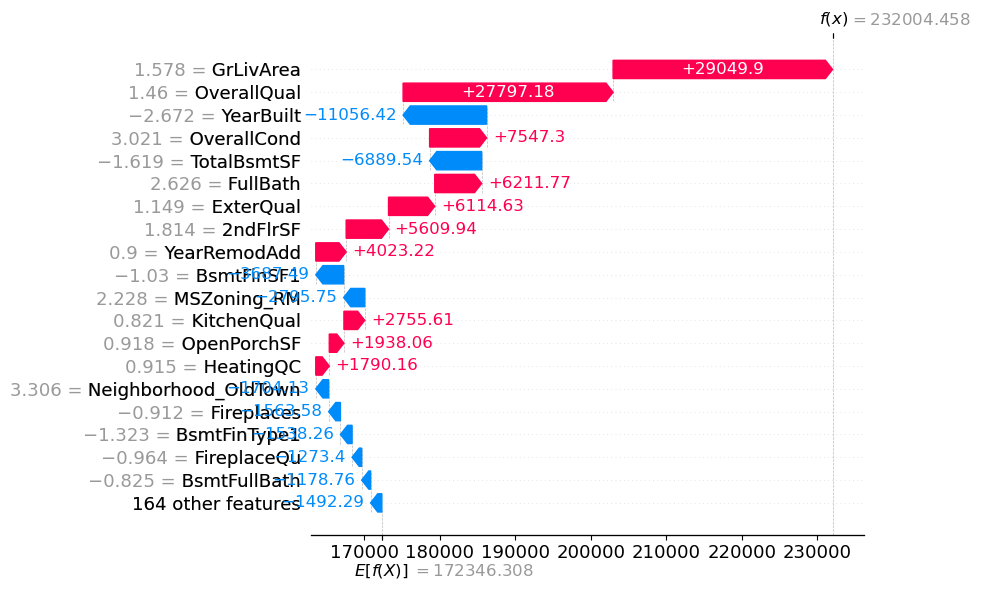

In [59]:
import matplotlib.pyplot as plt

# (you already have...)
fig = shap.plots.waterfall(shap_expln[0], max_display=20, show=False)
ax  = plt.gca()

# 1) Enlarge the figure & push the axes right
fig = plt.gcf()
fig.set_size_inches(10, 6)
fig.subplots_adjust(left=.5)    # leave 25% of the canvas as left margin

# 2) Pad the y‑labels far to the left
ax.tick_params(axis='y', pad=.5)  # move labels away from the axis

# 3) Right‑align the labels within that margin
for lbl in ax.get_yticklabels():
    lbl.set_ha('right')

plt.tight_layout()
plt.show()


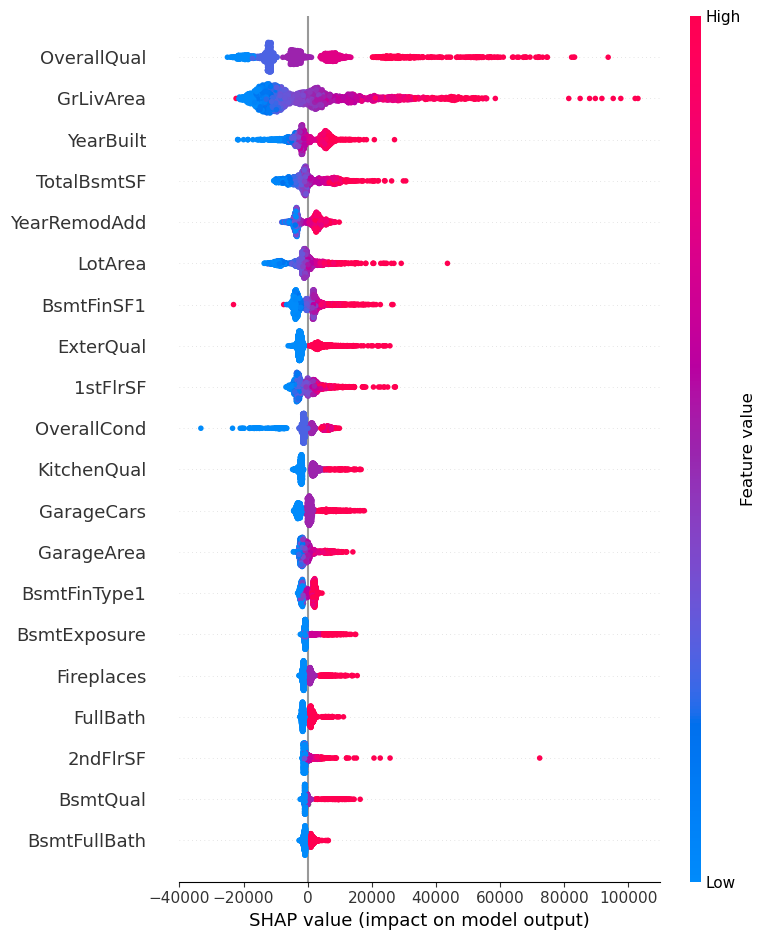

In [ ]:
shap.summary_plot(
    shap_expln.values,      # raw (n_samples × n_features) array
    X_train_scaled,         # DataFrame → supplies feature names
    max_display=20,
    plot_type="dot"         # same as a beeswarm
)

'''for OverallQual in your plot, you’d expect to see its high‐quality homes (reds) 
pulling the SHAP value positive—boosting price—while low‐quality homes (blues) push 
the SHAP value negative—lowering the predicted sale price.'''

# Pycaret
I am using Pycaret to identify the best predictive models

In [77]:
from pycaret.regression import setup, compare_models

# 0) Make sure both X and y have a fresh integer index
X = X_train_scaled.reset_index(drop=True)
y = y_train.reset_index(drop=True).rename("target")

# 1) Glue them together with no alignment hassles
train_data = pd.concat([X, y], axis=1)

# 1) Quick setup (using your train_data from earlier)
reg_setup = setup(
    data=train_data,
    target='target',
    session_id=42,
    verbose = False, 
    html = False
)

# 2) Pick a baseline model (or let PyCaret choose)
base = compare_models(turbo=True)  
#   ➞ turbo=True skips slower algos so it runs faster

# 3) Tune it “quickly”
tuned = tune_model(
    base,
    n_iter=20,                  # only 20 trials
    optimize='R2'            # or 'MAE', 'R2', etc.
)

# 4) Finalize & predict
final = finalize_model(tuned)

                                    Model           MAE           MSE  \
huber                     Huber Regressor  1.519134e+04  6.604464e+08   
lightgbm  Light Gradient Boosting Machine  1.432883e+04  6.643607e+08   
br                         Bayesian Ridge  1.617720e+04  6.828365e+08   
llar         Lasso Least Angle Regression  1.630532e+04  6.956069e+08   
en                            Elastic Net  1.606653e+04  7.216401e+08   
ridge                    Ridge Regression  1.672373e+04  7.006845e+08   
lasso                    Lasso Regression  1.674243e+04  7.016901e+08   
gbr           Gradient Boosting Regressor  1.434293e+04  7.104651e+08   
rf                Random Forest Regressor  1.574855e+04  7.797218e+08   
et                  Extra Trees Regressor  1.563597e+04  7.897904e+08   
omp           Orthogonal Matching Pursuit  1.807173e+04  8.034334e+08   
xgboost         Extreme Gradient Boosting  1.575680e+04  8.062315e+08   
par          Passive Aggressive Regressor  1.639080

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 20 candidates, totalling 200 fits


             MAE           MSE        RMSE      R2   RMSLE    MAPE
Fold                                                              
0     12662.5292  3.284329e+08  18122.7176  0.9037  0.1185  0.0789
1     15839.0686  1.082353e+09  32899.1316  0.8459  0.1768  0.1065
2     14051.8689  3.504586e+08  18720.5392  0.9337  0.1104  0.0847
3     18742.6284  1.070773e+09  32722.6751  0.8598  0.1472  0.0939
4     15622.5653  6.577306e+08  25646.2593  0.8912  0.1223  0.0858
5     13142.5774  3.265071e+08  18069.5077  0.9110  0.1058  0.0781
6     14966.1282  6.638160e+08  25764.6278  0.9073  0.1811  0.0815
7     17615.9668  1.313008e+09  36235.4504  0.7385  0.1592  0.1125
8     13041.2148  2.806917e+08  16753.8556  0.9169  0.0937  0.0750
9     14925.4390  4.744672e+08  21782.2689  0.9112  0.1859  0.0998
Mean  15060.9987  6.548238e+08  24671.7033  0.8819  0.1401  0.0897
Std    1885.7691  3.561678e+08   6791.9726  0.0540  0.0325  0.0122
